<h1><center> OCT PROJET 


In [ ]:
import os

import cv2
import glob
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import medfilt, savgol_filter
from random import randint

<h2> Normalisation des images

In [18]:

# --- Configuration ---
BASE_DATA_PATH = "./"
IMAGE_DIR = os.path.join(BASE_DATA_PATH, "Rad+cubeOD\OD\RAD")
OUTPUT_DIR = os.path.join(BASE_DATA_PATH, "rad_cropped") # Dossier pour les images recadrées
os.makedirs(OUTPUT_DIR, exist_ok=True)

CROP_X_START = 500 
CROP_Y_START = 20   
CROP_X_END = 1500
CROP_Y_END = 450   
taille_image = (CROP_Y_END - CROP_Y_START , CROP_X_END - CROP_X_START)

In [19]:

# --- Fonctions ---
def load_image(image_path):
    img = cv2.imread(image_path) # Charger en couleur au cas où pour l'affichage
    if img is None:
        print(f"Erreur : Impossible de charger l'image à {image_path}")
    return img

def crop_image(image, x_start, y_start, x_end, y_end):
    if image is None:
        return None
    # S'assurer que les coordonnées sont valides
    h, w = image.shape[:2]
    x_s = max(0, x_start)
    y_s = max(0, y_start)
    x_e = min(w, x_end)
    y_e = min(h, y_end)

    if x_s >= x_e or y_s >= y_e:
        print(f"Erreur de recadrage: coordonnées invalides ({x_s},{y_s}) à ({x_e},{y_e}) pour une image de taille {w}x{h}")
        return image # ou None
    
    cropped = image[y_s:y_e, x_s:x_e]
    return cropped

def display_comparison(original_img, cropped_img, title_original="Originale", title_cropped="Recadrée"):
    if original_img is None or cropped_img is None:
        print("Une des images est None, impossible d'afficher.")
        return
        
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
    plt.title(title_original)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB))
    plt.title(title_cropped)
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

def display_image(image):
    
    plt.imshow(image, cmap='gray')
    plt.show()


In [20]:
def crop_bscan():
    '''  Recadre les B-scans d'une série d'images en fonction des coordonnées définies'''

    # --- Script Principal ---
    image_files = glob.glob(os.path.join(IMAGE_DIR, "*.tif")) # Ou .png, .jpg
    if not image_files:
        print(f"Aucun fichier .tif trouvé dans {IMAGE_DIR}. Vérifiez le chemin et l'extension.")
        exit()

    # Traiter une seule image pour tester les coordonnées de recadrage
    test_image_path = image_files[0] # Prendre la première image
    print(f"Traitement de l'image test: {test_image_path}")

    full_image = load_image(test_image_path)

    if full_image is not None:
        # Afficher les dimensions pour aider à déterminer les coordonnées
        print(f"Dimensions de l'image complète: {full_image.shape} (hauteur, largeur, canaux)")
        
        # Appliquer le recadrage
        # VOUS DEVEZ AJUSTER CROP_X_START, CROP_Y_START, CROP_X_END, CROP_Y_END
        cropped_bscan = crop_image(full_image, CROP_X_START, CROP_Y_START, CROP_X_END, CROP_Y_END)

        if cropped_bscan is not None and cropped_bscan.size > 0 :
            print(f"Dimensions de l'image recadrée: {cropped_bscan.shape}")
            display_comparison(full_image, cropped_bscan, 
                            title_original=f"Originale ({os.path.basename(test_image_path)})", 
                            title_cropped=f"B-Scan Recadré (Coords: x[{CROP_X_START}:{CROP_X_END}], y[{CROP_Y_START}:{CROP_Y_END}])")
            
            # Optionnel: Sauvegarder l'image recadrée
            # output_filename = os.path.join(OUTPUT_DIR, "cropped_" + os.path.basename(test_image_path))
            # cv2.imwrite(output_filename, cropped_bscan)
            # print(f"Image recadrée sauvegardée ici : {output_filename}")
        else:
            print("Le recadrage a produit une image vide ou None.")
            if full_image is not None:
                plt.imshow(cv2.cvtColor(full_image, cv2.COLOR_BGR2RGB))
                plt.title("Image originale (échec du recadrage)")
                plt.show()


    # Une fois que vous êtes satisfait des coordonnées pour UNE image,
    # vous pouvez décommenter cette boucle pour traiter toutes les images :

    print("\n--- Traitement de toutes les images ---")
    for img_path in image_files:
        print(f"Traitement de : {img_path}")
        current_full_image = load_image(img_path)
        if current_full_image is not None:
            current_cropped_bscan = crop_image(current_full_image, CROP_X_START, CROP_Y_START, CROP_X_END, CROP_Y_END)
            if current_cropped_bscan is not None and current_cropped_bscan.size > 0:
                output_filename = os.path.join(OUTPUT_DIR, "cropped_" + os.path.basename(img_path))
                # Convertir en niveaux de gris avant de sauvegarder si vous ne voulez que le B-scan en gris
                # current_cropped_bscan_gray = cv2.cvtColor(current_cropped_bscan, cv2.COLOR_BGR2GRAY)
                # cv2.imwrite(output_filename, current_cropped_bscan_gray)
                cv2.imwrite(output_filename, current_cropped_bscan) # Sauvegarde en couleur (ou comme l'original)
                print(f"  -> Sauvegardée : {output_filename}")
            else:
                print(f"  -> Échec du recadrage pour {img_path}")


<h1> Segmentation de la rétine

<h2> Décomposition en 3 méthodes différentes


Méthode n°1 : 
<br>-Prétraitement (par B-scan recadré) : Améliorer la qualité de l'image pour faciliter la segmentation.
<br>-Segmentation de l'ILM (Internal Limiting Membrane) : C'est la première interface hyper-réflective (brillante) en partant du vitré (la zone sombre en haut).
<br>-Segmentation de la Limite Externe du HRC (Hyper-Reflective Complex) : C'est une autre couche brillante, plus profonde que l'ILM. Sa position est souvent relative à l'ILM.
<br>-Post-traitement : Lisser les courbes segmentées, combler les petits trous.

In [21]:
def get_image_files(DIR):
    
    return glob.glob(os.path.join(DIR, "*.tif"))
    
            
            



def pre_filtrage(cropped_bscan):

    gray_bscan = cv2.cvtColor(cropped_bscan, cv2.COLOR_BGR2GRAY)

    # Filtre Gaussien
    blurred = cv2.GaussianBlur(gray_bscan, (5, 5), 0) # Ajustez la taille du noyau

    # Ou Filtre Médian (bon pour le bruit poivre et sel)
    blurred = cv2.medianBlur(gray_bscan, 5)

    # CLAHE (Contrast Limited Adaptive Histogram Equalization)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    contrast_enhanced = clahe.apply(blurred)
    image_to_process = contrast_enhanced
    # Ou utiliser 'blurred' directement si le contraste est déjà bon
    return blurred


def segment_ilm_gradient_based(image_processed):
    ilm_line = np.zeros(image_processed.shape[1], dtype=int)
    # Réduire la zone de recherche pour l'ILM (par exemple, le tiers supérieur de l'image)
    search_roi_y_end = image_processed.shape[0] 

    for x in range(image_processed.shape[1]):
        column = image_processed[:search_roi_y_end, x]
        
        # Calculer le gradient vertical (différence simple ou Sobel)
        # grad_y = np.diff(column.astype(float)) # Simple diff, longueur N-1
        # Ou utiliser Sobel pour un gradient plus robuste
        sobel_y = cv2.Sobel(column, cv2.CV_64F, 0, 1, ksize=3) # Gradient en Y

        # Trouver le premier pic positif important
        # On cherche une transition sombre -> clair, donc un gradient positif important
        # (ou un pic négatif si on utilise diff et qu'on regarde la valeur d'avant)
        
        # Simplification: trouver le premier pixel au-dessus d'un seuil après lissage
        # Cette partie est très similaire à la méthode simple mais sur une image mieux préparée
        # et avec un ROI. Une vraie détection de pic de gradient serait mieux.
        
        # Pour une approche "premier pixel au-dessus d'un seuil dans ROI" (plus simple à coder ici)
        threshold_val = np.mean(column) + np.std(column) # Seuil adaptatif simple
        potential_points = np.where(column > threshold_val)[0]

        if len(potential_points) > 0:
            ilm_line[x] = potential_points[0]
        else:
            # Gérer le cas où rien n'est trouvé (ex: prendre la moyenne des voisins)
            if x > 0:
                ilm_line[x] = ilm_line[x-1] 
            else:
                ilm_line[x] = search_roi_y_end // 2 # Estimation grossière
    return ilm_line

def segment_hrc_relative_to_ilm(image_processed, ilm_line, search_offset=30, search_height=100):
    hrc_line = np.zeros(image_processed.shape[1], dtype=int)
    
    for x in range(image_processed.shape[1]):
        start_y_hrc = ilm_line[x] + search_offset
        end_y_hrc = min(image_processed.shape[0], start_y_hrc + search_height)
        
        if start_y_hrc >= end_y_hrc: # Si l'ILM est trop basse ou la bande trop petite
             if x > 0: hrc_line[x] = hrc_line[x-1]
             else: hrc_line[x] = ilm_line[x] + search_offset + search_height//2
             continue

        column_roi = image_processed[start_y_hrc:end_y_hrc, x]
        
        if column_roi.size == 0:
            if x > 0: hrc_line[x] = hrc_line[x-1]
            else: hrc_line[x] = ilm_line[x] + search_offset + search_height//2
            continue

        # Trouver le pixel le plus brillant dans ce ROI
        # Ceci est une simplification. Une détection de gradient ou de pic serait mieux.
        max_intensity_idx_in_roi = np.argmax(column_roi)
        hrc_line[x] = start_y_hrc + max_intensity_idx_in_roi
        
    return hrc_line

import numpy as np
import cv2 # Uniquement pour cv2.Sobel si vous l'utilisez plus tard, sinon pas besoin ici

def segment_hrc_band(image_processed, ilm_line,
                     offset_to_hrc_top_search_start=25, # Augmenté par défaut
                     hrc_complex_search_height=100,
                     hrc_band_expected_min_thickness=10,
                     hrc_band_expected_max_thickness=50,
                     hrc_top_brightness_factor_vs_ilm=1.15, # HRC_top doit être X% plus brillant que l'ILM
                     hrc_top_brightness_factor_vs_roi_mean=1.0 # HRC_top doit être X * std_dev au-dessus de la moyenne ROI HRC
                    ):
    hrc_top_line = np.zeros(image_processed.shape[1], dtype=float)
    hrc_bottom_line = np.zeros(image_processed.shape[1], dtype=float)
    img_height, img_width = image_processed.shape

    for x in range(img_width):
        # Définir la ROI verticale globale pour chercher le complexe HRC
        # S'assurer que ilm_line[x] est un index valide
        current_ilm_y = int(ilm_line[x])
        if not (0 <= current_ilm_y < img_height): # Si ILM est hors limites, fallback
            current_ilm_y = img_height // 3 # Estimation grossière

        search_roi_start_y = current_ilm_y + offset_to_hrc_top_search_start
        search_roi_end_y = min(img_height, search_roi_start_y + hrc_complex_search_height)

        # S'assurer que la ROI est valide et a une taille minimale
        if search_roi_start_y >= img_height or search_roi_start_y >= search_roi_end_y or (search_roi_end_y - search_roi_start_y) < 5 :
            hrc_top_line[x] = hrc_top_line[x-1] if x > 0 else current_ilm_y + offset_to_hrc_top_search_start + 5
            hrc_bottom_line[x] = hrc_bottom_line[x-1] if x > 0 else hrc_top_line[x] + hrc_band_expected_min_thickness + 5
            hrc_top_line[x] = min(max(0, hrc_top_line[x]), img_height -1) # Clamp
            hrc_bottom_line[x] = min(max(0, hrc_bottom_line[x]), img_height -1) # Clamp
            continue

        column_hrc_roi = image_processed[int(search_roi_start_y):int(search_roi_end_y), x]

        if column_hrc_roi.size == 0: # Devrait être couvert par la vérification précédente, mais par sécurité
            hrc_top_line[x] = hrc_top_line[x-1] if x > 0 else current_ilm_y + offset_to_hrc_top_search_start + 5
            hrc_bottom_line[x] = hrc_bottom_line[x-1] if x > 0 else hrc_top_line[x] + hrc_band_expected_min_thickness + 5
            hrc_top_line[x] = min(max(0, hrc_top_line[x]), img_height -1)
            hrc_bottom_line[x] = min(max(0, hrc_bottom_line[x]), img_height -1)
            continue

        # --- Trouver HRC_top ---
        current_hrc_top_local_idx = -1

        # Définir un seuil d'intensité exigeant pour HRC_top
        intensity_at_ilm = image_processed[current_ilm_y, x]
        
        # Seuil 1: basé sur la brillance relative à l'ILM
        threshold_vs_ilm = intensity_at_ilm * hrc_top_brightness_factor_vs_ilm
        
        # Seuil 2: basé sur la distribution de la ROI HRC
        mean_roi = np.mean(column_hrc_roi)
        std_roi = np.std(column_hrc_roi)
        threshold_vs_roi_stat = mean_roi + hrc_top_brightness_factor_vs_roi_mean * std_roi
        
        # Le seuil final est le plus strict des deux (ou d'autres combinaisons)
        # Ici, on prend le max, ce qui signifie que le pixel doit satisfaire les deux conditions si elles sont pertinentes
        # Ou une condition OU l'autre, selon la logique (ici, on prend le max pour être plus strict)
        final_threshold_top = max(threshold_vs_ilm, threshold_vs_roi_stat, mean_roi + 5) # Ajout d'un seuil minimal au-dessus de la moyenne

        # Chercher le premier pixel dans column_hrc_roi qui dépasse ce seuil strict
        # On limite la recherche à la première partie de la ROI pour éviter confusion avec HRC_bottom
        search_limit_hrc_top_local = len(column_hrc_roi) * 2 // 3 # ex: chercher dans les 2/3 supérieurs de la ROI HRC
        
        potential_top_indices = np.where(column_hrc_roi[:search_limit_hrc_top_local] > final_threshold_top)[0]
        
        if len(potential_top_indices) > 0:
            current_hrc_top_local_idx = potential_top_indices[0]
        else:
            # Fallback si le seuil strict ne trouve rien:
            # Chercher le pixel le plus brillant dans la première moitié de la ROI HRC.
            # Cela peut arriver si l'HRC n'est pas aussi brillant que prévu par les facteurs.
            first_half_roi = column_hrc_roi[:len(column_hrc_roi)//2]
            if first_half_roi.size > 0:
                current_hrc_top_local_idx = np.argmax(first_half_roi)
            else: # Si même la première moitié est vide (ROI très petite)
                current_hrc_top_local_idx = 0 # Prendre le début de la ROI

        # Si current_hrc_top_local_idx est toujours -1 (ce qui ne devrait pas arriver avec le fallback argmax),
        # ou s'il est trop bas dans la ROI (ce qui contredit l'idée de "top")
        # Ce fallback est moins probable maintenant.
        if current_hrc_top_local_idx == -1 : # Ne devrait plus arriver
             max_intensity_idx_in_overall_roi = np.argmax(column_hrc_roi)
             current_hrc_top_local_idx = max(0, max_intensity_idx_in_overall_roi - hrc_band_expected_min_thickness//2) # Estimation

        hrc_top_line[x] = search_roi_start_y + current_hrc_top_local_idx


        # --- Trouver HRC_bottom ---
        # (La logique pour HRC_bottom reste globalement la même que votre version précédente,
        # mais elle commence sa recherche à partir du HRC_top trouvé)

        # Assurer que HRC_top n'est pas trop bas pour laisser de la place à HRC_bottom
        # Et que start_search_bottom_local_idx est valide
        # On veut que HRC_bottom soit au moins quelques pixels après HRC_top
        min_dist_top_to_start_bottom = max(1, hrc_band_expected_min_thickness // 3) # Ex: au moins 1/3 de l'épaisseur min
        start_search_bottom_local_idx = int(current_hrc_top_local_idx + min_dist_top_to_start_bottom)
        
        # S'assurer que start_search_bottom_local_idx ne dépasse pas la fin de column_hrc_roi
        if start_search_bottom_local_idx >= len(column_hrc_roi):
            # Si HRC_top est trop proche de la fin de la ROI, HRC_bottom est juste un peu après
            hrc_bottom_line[x] = hrc_top_line[x] + hrc_band_expected_min_thickness
            hrc_bottom_line[x] = min(hrc_bottom_line[x], search_roi_end_y -1) # borner
            # Il faut s'assurer que top et bottom sont cohérents dans le script principal après lissage
            continue # Passer à la colonne suivante

        sub_roi_for_bottom = column_hrc_roi[start_search_bottom_local_idx:]
        current_hrc_bottom_local_idx = -1

        if sub_roi_for_bottom.size > 0:
            max_intensity_idx_in_sub_roi = np.argmax(sub_roi_for_bottom)
            intensity_at_max_in_sub_roi = sub_roi_for_bottom[max_intensity_idx_in_sub_roi]
            
            # Seuil pour HRC_bottom: un certain pourcentage de l'intensité max trouvée dans la sous-ROI
            # Ou un peu plus bas que HRC_top si HRC_top est le plus brillant de toute la bande
            threshold_bottom = intensity_at_max_in_sub_roi * 0.85 # Doit être encore assez brillant (ajustable)
            # S'assurer que threshold_bottom n'est pas trop bas si toute la bande est peu contrastée
            threshold_bottom = max(threshold_bottom, mean_roi * 0.9) # Au moins 90% de la moyenne de la ROI HRC

            last_bright_pixel_idx_in_sub_roi = max_intensity_idx_in_sub_roi # Initialiser
            for i in range(max_intensity_idx_in_sub_roi, len(sub_roi_for_bottom)):
                if sub_roi_for_bottom[i] >= threshold_bottom:
                    last_bright_pixel_idx_in_sub_roi = i
                else:
                    # On peut ajouter une condition pour ne pas s'arrêter trop tôt si c'est juste un petit creux
                    # Si les N prochains pixels sont aussi sous le seuil, alors on s'arrête.
                    # Pour l'instant, on s'arrête au premier passage sous le seuil.
                    break
            current_hrc_bottom_local_idx = start_search_bottom_local_idx + last_bright_pixel_idx_in_sub_roi
        
        if current_hrc_bottom_local_idx == -1: # Fallback si sub_roi_for_bottom était vide ou autre souci
            max_intensity_idx_in_overall_roi = np.argmax(column_hrc_roi) # Reprendre la ROI HRC complète
            # Placer HRC_bottom un peu après le HRC_top trouvé ou le max global
            offset_from_top = max(hrc_band_expected_min_thickness, (max_intensity_idx_in_overall_roi - current_hrc_top_local_idx) if max_intensity_idx_in_overall_roi > current_hrc_top_local_idx else hrc_band_expected_min_thickness)
            current_hrc_bottom_local_idx = min(len(column_hrc_roi)-1, current_hrc_top_local_idx + offset_from_top)

        hrc_bottom_line[x] = search_roi_start_y + current_hrc_bottom_local_idx

        # --- Vérifications finales pour la colonne x ---
        # S'assurer que HRC_bottom est après HRC_top
        if hrc_bottom_line[x] <= hrc_top_line[x]:
            hrc_bottom_line[x] = hrc_top_line[x] + hrc_band_expected_min_thickness

        # S'assurer que l'épaisseur est dans les limites attendues (si possible)
        current_thickness = hrc_bottom_line[x] - hrc_top_line[x]
        if current_thickness < hrc_band_expected_min_thickness:
            hrc_bottom_line[x] = hrc_top_line[x] + hrc_band_expected_min_thickness
        elif current_thickness > hrc_band_expected_max_thickness:
            # Si trop épais, on peut soit remonter HRC_bottom soit descendre HRC_top.
            # Remonter HRC_bottom est souvent plus sûr si HRC_top est bien placé.
            hrc_bottom_line[x] = hrc_top_line[x] + hrc_band_expected_max_thickness
        
        # Clamper les valeurs pour qu'elles restent dans les limites de l'image
        hrc_top_line[x] = min(max(0, hrc_top_line[x]), img_height - 1)
        hrc_bottom_line[x] = min(max(0, hrc_bottom_line[x]), img_height - 1)
        
        # S'assurer que bottom est toujours après top après clamping et ajustements d'épaisseur
        if hrc_bottom_line[x] < hrc_top_line[x]:
            hrc_bottom_line[x] = hrc_top_line[x] # Au pire, épaisseur nulle, à gérer après lissage

    return hrc_top_line.astype(int), hrc_bottom_line.astype(int)


def post_filtrage(ilm_line, hrc_lines):
    """ il faut appliquer un gros filtre pour enlever les taches noires ! """
    # Appliquer un filtre médian
    ilm_line_smooth = medfilt(ilm_line, kernel_size=15).astype(int) # Ajustez kernel_size
    hrc_line_top_smooth = medfilt(hrc_lines[0], kernel_size=21).astype(int)
    hrc_line_bot_smooth = medfilt(hrc_lines[1], kernel_size=21).astype(int)

    return ilm_line_smooth, hrc_line_top_smooth,hrc_line_bot_smooth



            
    

In [22]:
def create_and_save_retinal_layer_masks(
    ilm_line,
    hrc_top_line,
    hrc_bottom_line,
    image_shape,
    output_directory="mask_result",
    base_filename="mask",
    visualize=False # Option pour afficher les masques générés
):
    """
    Crée et sauvegarde les masques binaires pour deux couches rétiniennes :
    1. La couche entre l'ILM (ligne supérieure) et le HRC_top (couche "supra-HRC").
    2. La bande HRC (entre HRC_top et HRC_bottom).

    Les masques sont sauvegardés en format PNG avec des valeurs de 0 (noir) et 255 (blanc).

    Args:
        ilm_line (np.array): Array 1D des positions Y de la ligne ILM.
        hrc_top_line (np.array): Array 1D des positions Y de la bordure supérieure du HRC.
        hrc_bottom_line (np.array): Array 1D des positions Y de la bordure inférieure du HRC.
        image_shape (tuple): Forme (hauteur, largeur) de l'image de référence.
        output_directory (str): Dossier où sauvegarder les masques.
        base_filename (str): Nom de base pour les fichiers de masques sauvegardés.
        visualize (bool): Si True, affiche les masques générés.
    """
    img_height, img_width = image_shape

    # Vérification de la cohérence des longueurs des lignes
    if not (len(ilm_line) == img_width and \
            len(hrc_top_line) == img_width and \
            len(hrc_bottom_line) == img_width):
        raise ValueError("La longueur des lignes (ILM, HRC_top, HRC_bottom) "
                         "doit correspondre à la largeur de l'image.")

    # Créer le dossier de sortie s'il n'existe pas
    os.makedirs(output_directory, exist_ok=True)

    # --- Masque 1: Couche "Supra-HRC" (entre ILM et HRC_top) ---
    mask_supra_hrc = np.zeros(image_shape, dtype=np.uint8)
    for x in range(img_width):
        y_start_supra = int(ilm_line[x])
        y_end_supra = int(hrc_top_line[x]) # HRC_top est la limite *exclusive* de cette couche

        # S'assurer que les coordonnées sont valides et que y_end est après y_start
        if 0 <= y_start_supra < img_height and \
           0 <= y_end_supra < img_height and \
           y_start_supra < y_end_supra: # Strictement inférieur car HRC_top est le début de la couche suivante
            mask_supra_hrc[y_start_supra:y_end_supra, x] = 1
            # Si ilm_line est la PREMIERE ligne de la couche et hrc_top_line est la PREMIERE ligne
            # de la couche HRC, alors la couche supra-HRC va de ilm_line[x] inclus à hrc_top_line[x] exclus.
            # Le slicing [start:end] fait exactement cela.

    # --- Masque 2: Bande HRC (entre HRC_top et HRC_bottom) ---
    mask_hrc_band = np.zeros(image_shape, dtype=np.uint8)
    for x in range(img_width):
        y_start_hrc = int(hrc_top_line[x])
        # hrc_bottom_line est considérée comme la DERNIÈRE ligne incluse dans la bande HRC
        y_end_hrc_inclusive = int(hrc_bottom_line[x])

        # S'assurer que les coordonnées sont valides et que y_end est après ou égale à y_start
        if 0 <= y_start_hrc < img_height and \
           0 <= y_end_hrc_inclusive < img_height and \
           y_start_hrc <= y_end_hrc_inclusive:
            mask_hrc_band[y_start_hrc : min(img_height, y_end_hrc_inclusive + 1), x] = 1

    # Sauvegarde des masques (en multipliant par 255 pour la visibilité)
    supra_hrc_mask_filename = os.path.join(output_directory, f"{base_filename}_mask_supra_HRC.png")
    hrc_band_mask_filename = os.path.join(output_directory, f"{base_filename}_mask_HRC_band.png")

    try:
        cv2.imwrite(supra_hrc_mask_filename, mask_supra_hrc * 255)
        print(f"Masque Supra-HRC sauvegardé : {supra_hrc_mask_filename}")
    except Exception as e:
        print(f"Erreur lors de la sauvegarde de {supra_hrc_mask_filename}: {e}")

    try:
        cv2.imwrite(hrc_band_mask_filename, mask_hrc_band * 255)
        print(f"Masque Bande HRC sauvegardé : {hrc_band_mask_filename}")
    except Exception as e:
        print(f"Erreur lors de la sauvegarde de {hrc_band_mask_filename}: {e}")


    # Visualisation optionnelle
    if visualize:
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.imshow(mask_supra_hrc, cmap='gray')
        plt.title("Masque Couche Supra-HRC")
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(mask_hrc_band, cmap='gray')
        plt.title("Masque Bande HRC")
        plt.axis('off')

        plt.suptitle(f"Masques pour: {base_filename}")
        plt.tight_layout(rect=[0, 0, 1, 0.96]) # Ajuster pour le suptitle
        plt.show()

    return mask_supra_hrc, mask_hrc_band # Retourner les masques (0 et 1) pour une utilisation ultérieure si besoin

In [ ]:

def main_1(DIR):

    image_files = get_image_files(DIR)

    i=-1
    for image_path in image_files:
        file_name = os.path.splitext(os.path.basename(image_path))[0]
        image = load_image(image_path)
        i+=1
        
        pre_filtre = pre_filtrage(image)
        ilm = segment_ilm_gradient_based(pre_filtre)
        hrc = segment_hrc_band(pre_filtre, ilm)
        ilm_smooth, hrc_top_smooth,hrc_bot_smooth = post_filtrage(ilm, hrc)
        if (i+randint(0,10))%10==0:
            print(i,image_path)
            print('\n\nimage originale')
            display_image(image)
            print('image pré-filtrée')
            display_image(pre_filtre)
            print('ILM détectée')
            plt.plot(ilm, label='ILM')
            plt.plot(hrc[0], label='HRC_top')
            plt.plot(hrc[1], label='HRC_bot')
            print('image_pré-filtrée avec ILM et HRC')
            display_image(pre_filtre)
            plt.plot(ilm_smooth, label='ILM')
            plt.plot(hrc_top_smooth, label='HRC_top')
            plt.plot(hrc_bot_smooth, label='HRC_bot')
            print('image_pré-filtrée avec ILM et HRC lissées')
            display_image(pre_filtre)
            create_and_save_retinal_layer_masks(ilm,hrc_top_smooth,\
                hrc_bot_smooth,taille_image,base_filename=file_name,visualize=True)



Partie d'execution

9 ./rad_cropped\cropped_CONTROL_CHC_20241022_RAD_OD_009.tif


image originale


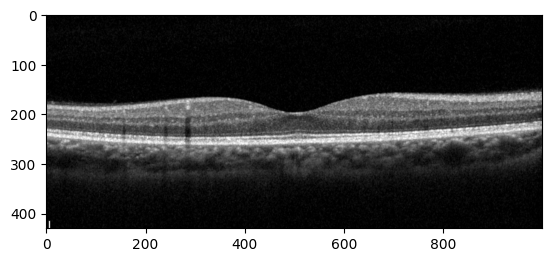

image pré-filtrée


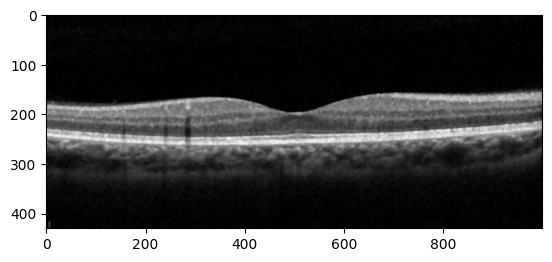

ILM détectée
image_pré-filtrée avec ILM et HRC


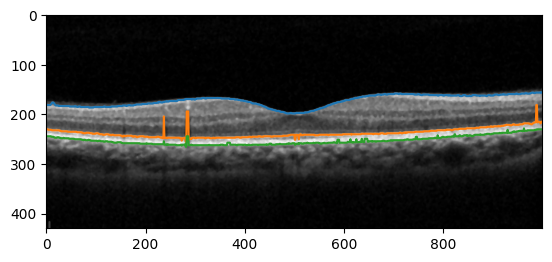

image_pré-filtrée avec ILM et HRC lissées


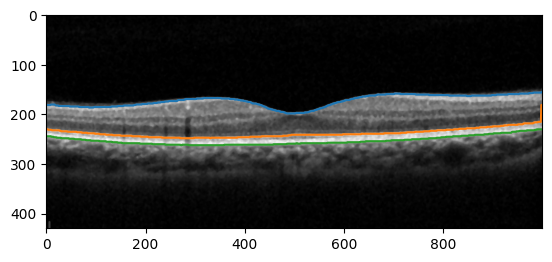

Masque Supra-HRC sauvegardé : mask_result\cropped_CONTROL_CHC_20241022_RAD_OD_009_mask_supra_HRC.png
Masque Bande HRC sauvegardé : mask_result\cropped_CONTROL_CHC_20241022_RAD_OD_009_mask_HRC_band.png


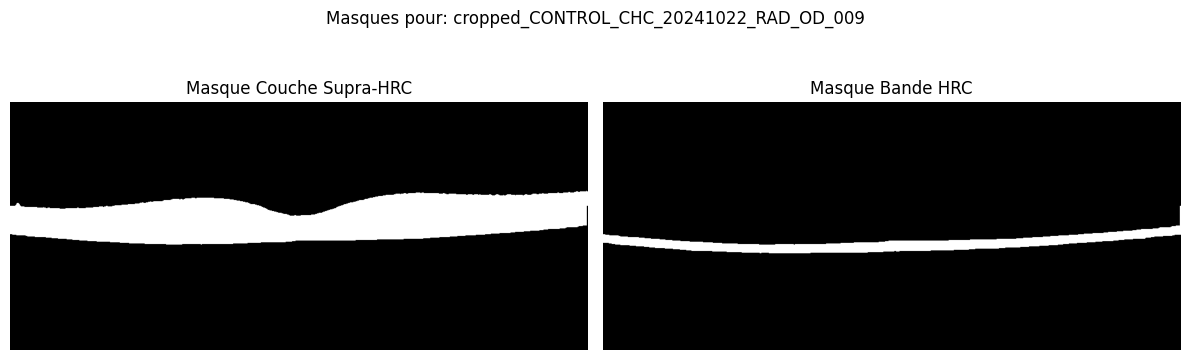

19 ./rad_cropped\cropped_CONTROL_CHC_20241022_RAD_OD_019.tif


image originale


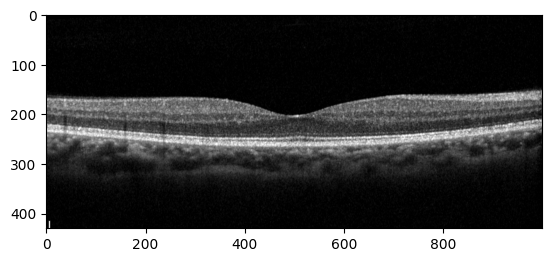

image pré-filtrée


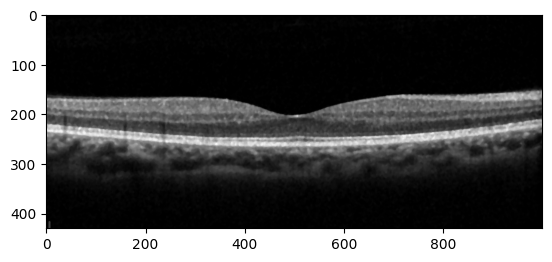

ILM détectée
image_pré-filtrée avec ILM et HRC


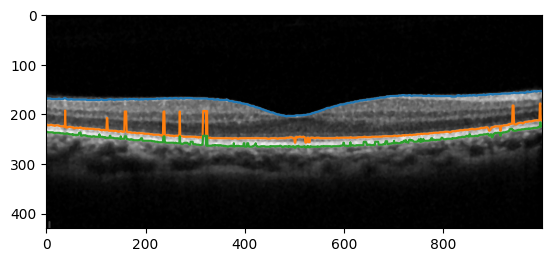

image_pré-filtrée avec ILM et HRC lissées


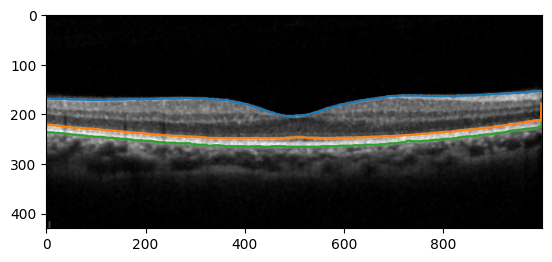

Masque Supra-HRC sauvegardé : mask_result\cropped_CONTROL_CHC_20241022_RAD_OD_019_mask_supra_HRC.png
Masque Bande HRC sauvegardé : mask_result\cropped_CONTROL_CHC_20241022_RAD_OD_019_mask_HRC_band.png


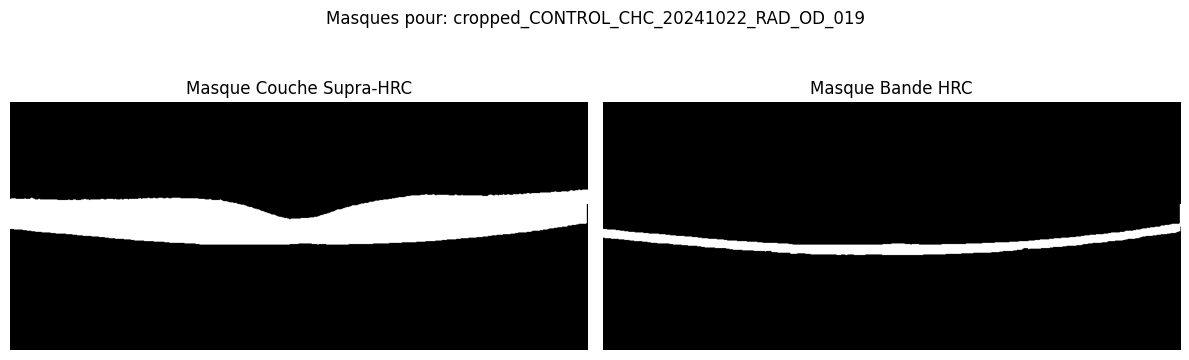

29 ./rad_cropped\cropped_CONTROL_CHC_20241022_RAD_OD_029.tif


image originale


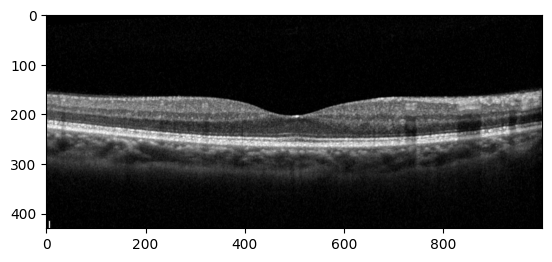

image pré-filtrée


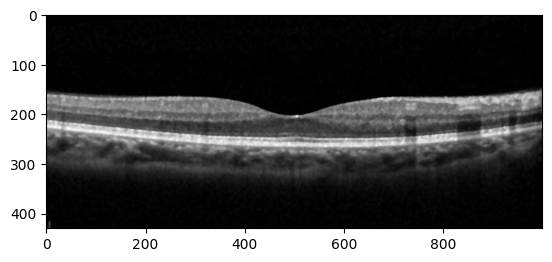

ILM détectée
image_pré-filtrée avec ILM et HRC


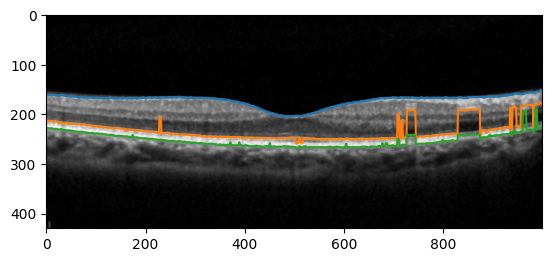

image_pré-filtrée avec ILM et HRC lissées


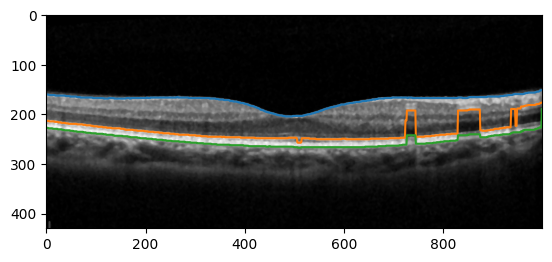

Masque Supra-HRC sauvegardé : mask_result\cropped_CONTROL_CHC_20241022_RAD_OD_029_mask_supra_HRC.png
Masque Bande HRC sauvegardé : mask_result\cropped_CONTROL_CHC_20241022_RAD_OD_029_mask_HRC_band.png


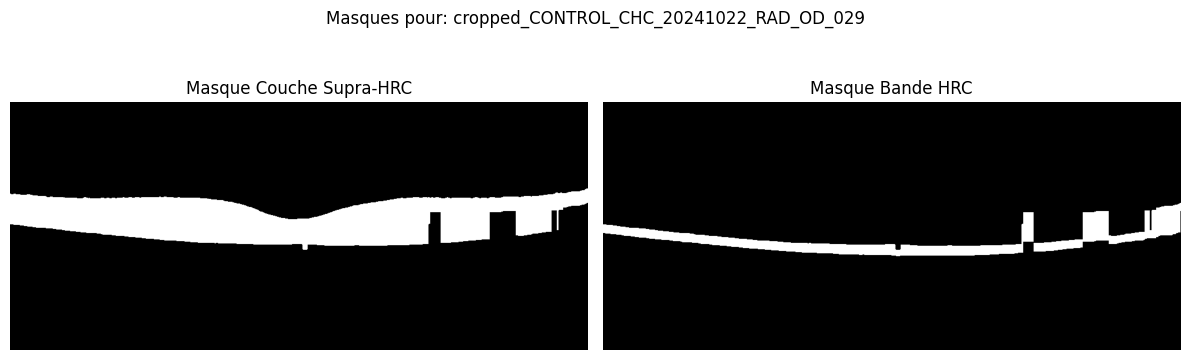

39 ./rad_cropped\cropped_CONTROL_CHC_20241022_RAD_OD_039.tif


image originale


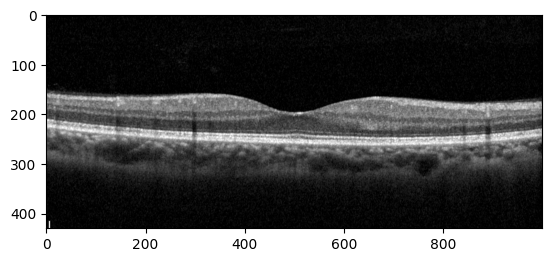

image pré-filtrée


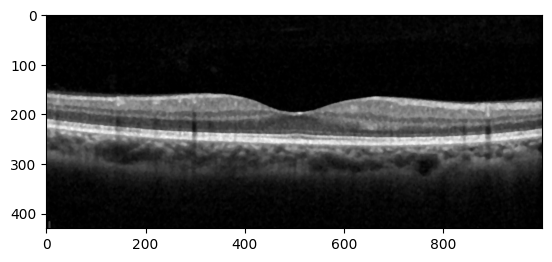

ILM détectée
image_pré-filtrée avec ILM et HRC


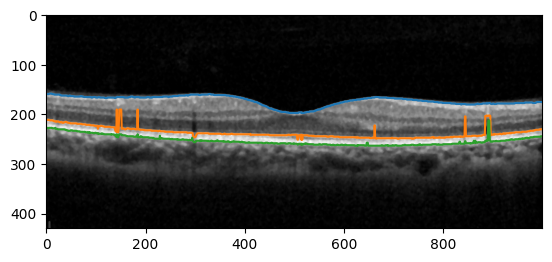

image_pré-filtrée avec ILM et HRC lissées


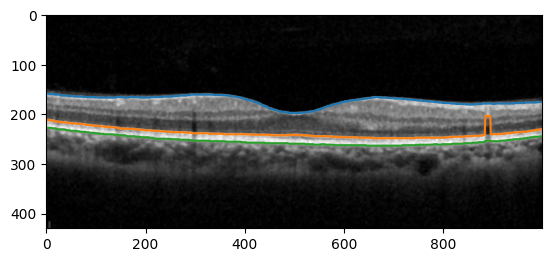

Masque Supra-HRC sauvegardé : mask_result\cropped_CONTROL_CHC_20241022_RAD_OD_039_mask_supra_HRC.png
Masque Bande HRC sauvegardé : mask_result\cropped_CONTROL_CHC_20241022_RAD_OD_039_mask_HRC_band.png


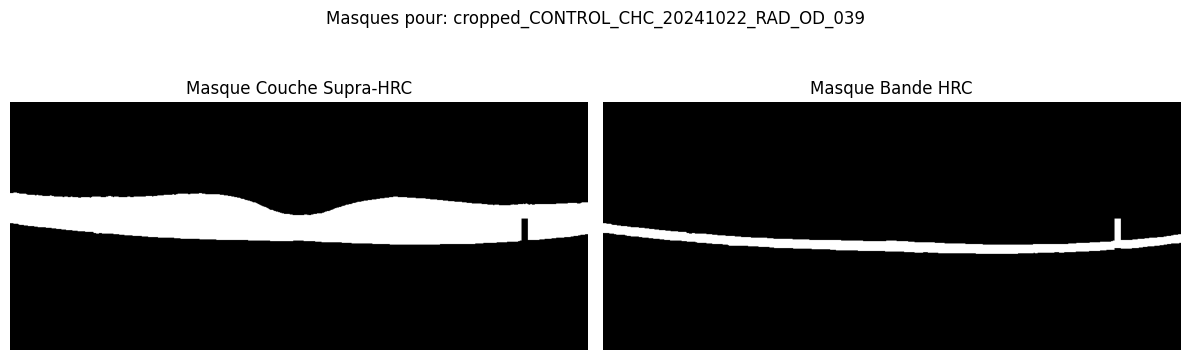

In [24]:
main_1(OUTPUT_DIR)

<h3>Découpage des zones en masques

<h2> Méthode n°2 : Segmentation Basée sur les Graphes

L'idée est de transformer l'image en un graphe où les pixels sont des nœuds et les coûts des arêtes dépendent des gradients d'intensité. On cherche ensuite le chemin de coût minimal entre deux points (ou dans une certaine direction).



PAS ENCORE FAIT

In [25]:
from skimage.graph import shortest_path
from skimage.filters import sobel_v # Pour le gradient vertical

def segment_layer_graph_search(image_processed, roi_y_start=None, roi_y_end=None):
    # Calculer le gradient vertical (plus le gradient est fort, plus le coût est bas)
    # On veut que les bords brillants soient des chemins de faible coût
    # L'ILM est une transition sombre->clair (gradient positif)
    # D'autres couches sont clair->sombre (gradient négatif)
    # On peut utiliser la magnitude du gradient ou un gradient directionnel
    
    gradient_image = sobel_v(image_processed)

    # Transformer le gradient en coûts : les forts gradients (bords) doivent avoir un faible coût.
    # Les valeurs négatives de sobel_v correspondent à une transition sombre->clair (bord supérieur de couche)
    # Les valeurs positives de sobel_v correspondent à une transition clair->sombre (bord inférieur de couche)
    
    # Pour l'ILM (bord supérieur, sombre vers clair): on veut un gradient négatif fort.
    # Donc on peut prendre -gradient_image (les grandes valeurs négatives deviennent grandes positives).
    # Ou on peut utiliser une fonction de coût plus sophistiquée.
    # Pour simplifier ici, on va dire que le coût est l'inverse de l'intensité (si couches brillantes)
    # OU mieux: coût faible là où le gradient vertical est fort dans la bonne direction.
    
    # Exemple simple: coût = max_intensity - intensity (pour couches brillantes)
    # costs = np.max(image_processed) - image_processed
    
    # Exemple basé sur gradient pour l'ILM (on cherche la transition sombre vers clair)
    # sobel_v donne des valeurs négatives pour sombre->clair en descendant.
    # On veut maximiser -sobel_v (ou minimiser sobel_v).
    # shortest_path minimise, donc on peut utiliser sobel_v directement si on cherche un gradient négatif.
    costs = gradient_image.copy()

    # Optionnel: contraindre la recherche à un ROI vertical
    if roi_y_start is not None and roi_y_end is not None:
        mask = np.ones_like(costs, dtype=bool)
        mask[roi_y_start:roi_y_end, :] = False
        costs[mask] = np.inf # Coût infini en dehors du ROI

    # Définir les points de départ et d'arrivée pour shortest_path
    # Typiquement, d'un côté à l'autre de l'image.
    # Pour chaque colonne, on trouve le point de départ et d'arrivée dans cette colonne.
    # Ici, on va trouver un chemin global.
    # Pour cela, on a besoin d'un point de départ (colonne 0) et de fin (dernière colonne).
    # On pourrait chercher le point de coût minimal dans la première et dernière colonne comme start/end.
    
    # Solution plus simple pour une ligne :
    # Itérer sur les colonnes, et à chaque colonne, décider du "saut" vers la colonne suivante
    # basé sur les coûts locaux. C'est ce que fait shortest_path en 2D.
    
    # Pour utiliser skimage.graph.shortest_path pour trouver une ligne d'un bord à l'autre:
    # Il faut spécifier des `goals` et des `sources`.
    # Une approche plus simple avec les graphes est d'utiliser des bibliothèques spécialisées
    # ou d'implémenter une version modifiée de Dijkstra.

    # Une autre façon de voir est de considérer une "image de coût cumulé"
    # dp_costs = np.zeros_like(costs)
    # dp_costs[:, 0] = costs[:, 0] # Initialiser la première colonne
    # for x_col in range(1, costs.shape[1]):
    #     for y_curr in range(costs.shape[0]):
    #         min_prev_cost = np.inf
    #         # Regarder les voisins dans la colonne précédente (-1, 0, +1 en y)
    #         for y_offset in [-1, 0, 1]:
    #             y_prev = y_curr + y_offset
    #             if 0 <= y_prev < costs.shape[0]:
    #                 min_prev_cost = min(min_prev_cost, dp_costs[y_prev, x_col-1])
    #         dp_costs[y_curr, x_col] = costs[y_curr, x_col] + min_prev_cost
    # # Ensuite, backtracking depuis le min de la dernière colonne.
    # C'est l'essence de la programmation dynamique pour la segmentation de couches.

    # Pour l'instant, restons sur une approche plus directe pour le code d'exemple.
    # La méthode gradient_based ci-dessus est une simplification de cela.
    # Une implémentation complète de graph search est plus longue.
    print("Graph search est plus complexe à implémenter directement ici.")
    print("Considérez des bibliothèques comme A* search ou Dijkstra avec des coûts bien définis.")
    print("Ou explorez des outils comme 'OCTLayerSegmentation' sur GitHub pour des implémentations.")
    return None # Remplacer par la ligne segmentée

<h2> Méthode n°3 Deep learning ave U-net

Voir TD11 de VPO